##3.3 Creating a BRDF model

In [1]:
import os
import numpy as np
import itertools
import multiprocessing
import ctypes
import glob
from run_start import *
from generate_camera_file import *
from plot_polar_contour import *
%matplotlib inline

##Method
With each iteration the azimuth and zenith view angles are permeated through angles 0 - 360$^{\circ}$ in 10$^{\circ}$ steps and nadir - 60$^{\circ}$ in 5$^{\circ}$ steps respectively.  The illumination azimuth and zenith angles are set to 90$^{\circ}$ and 75$^{\circ}$ repsectively in the <code><span style="background-color:lightgrey">light/brdf.light</span></code>.

This code introduces a Python module that can construct a <code><span style="background-color:lightgrey">*.camera</span></code> from a dictionary of commands. 

In [3]:
azimuth = np.arange(0, 370, 10)
zenith = -np.arange(-60, 0, 5)
coordinates = np.asarray(list(itertools.product(azimuth, zenith)))

In [4]:
# http://stackoverflow.com/questions/5549190/is-shared-readonly-data-copied-to-different-processes-for-python-multiprocessing/5550156#5550156

shared_array_base = multiprocessing.Array(ctypes.c_double, len(coordinates) * 3)
shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
shared_array = shared_array.reshape(len(coordinates), 3)

shared_array[:, :2] = coordinates

def process_(i, def_param=shared_array):
    
    A = shared_array[i, 0]
    Z = shared_array[i, 1]
    
    # create tmeporary camera file
    camera_fname = 'camera/brdf.{}.camera'.format(i)
    results_name = 'output/brdf.{}'.format(i)
    camera(camera_fname,
           geometry_options={'geometry.azimuth':A,
                             'geometry.zenith':Z,
                             'geometry.lookAt':[.2, 0, 5.36],
                             'geometry.idealArea':1},
           results_options={'oname':results_name},
           remove=['result.image'], overwrite=True)

    # run simulation
    cmd = "echo 14 {} light/brdf_light.dat | \
           start -RATm 5 -RATsensor_wavebands wb/brdf_waveband.dat \
           obj/birch_tree_scene.obj".format(camera_fname)
    error = run_start(cmd)

    # extract reflectance value
    shared_array[i, 2] = np.loadtxt(results_name + '.results.direct')[:, 1].sum()
    
    # delete files
    os.unlink(camera_fname)
    os.unlink(results_name + '.results')
    os.unlink(results_name + '.results.direct')
    os.unlink(results_name + '.results.diffuse')

if __name__ == '__main__':
    
    number_of_processes = 4
    estimated_time = (len(shared_array) / number_of_processes) / 60.
    
    print 'this will run {} tasks'.format(len(shared_array))
    print 'as each run takes ~1 min (on my mac) therefore whole process should take {:.2f} hours'.format(estimated_time)

    pool = multiprocessing.Pool(processes=number_of_processes)
    pool.map(process_, [i for i in range(len(shared_array))])

this will run 444 tasks
as each run takes ~1 min (on my mac) therefore whole process should take 1.85 hours


/Library/Python/2.7/site-packages/numpy-override/numpy/ctypeslib.py:408: RuntimeWarning: Item size computed from the PEP 3118 buffer format string does not match the actual item size.
  return array(obj, copy=False)


OSError: [Errno 2] No such file or directory

In [4]:
shared_array

array([[  0.00000000e+00,   6.00000000e+01,   1.33811512e-01],
       [  0.00000000e+00,   1.00000000e+01,   7.62678091e-02],
       [  1.00000000e+02,   6.00000000e+01,   1.37193345e-01],
       [  1.00000000e+02,   1.00000000e+01,   6.11439011e-02],
       [  2.00000000e+02,   6.00000000e+01,   1.33553287e-01],
       [  2.00000000e+02,   1.00000000e+01,   7.47020388e-02],
       [  3.00000000e+02,   6.00000000e+01,   1.30191315e-01],
       [  3.00000000e+02,   1.00000000e+01,   7.54661036e-02]])

In [5]:
brdf_array = shared_array[:, 2].reshape(len(azimuth), len(zenith))

(<matplotlib.figure.Figure at 0x10651e2d0>,
 <matplotlib.contour.QuadContourSet instance at 0x108aac128>)

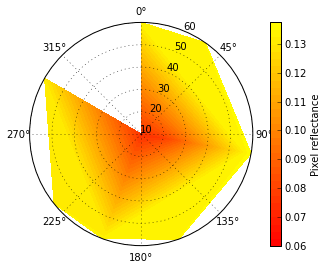

In [6]:
plot_polar_contour(brdf_array, azimuth, zenith)